# Italian vs. Mexican Food
---

The below script provides an analytic approach for assessing the American preference of Italian vs. Mexican food. Using data from the US Census and the Yelp API, the script randomly selects over 500 zip codes and aggregates the reviews of the 20 most popular Italian and Mexican restaurants in each area. Summary data is then reported using Python Pandas. 

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import json
import seaborn
from scipy.stats import ttest_ind

You'll need to have registered as a developer on the Yelp Developers website (https://www.yelp.com/login?return_url=%2Fdevelopers%2Fv3%2Fmanage_app) and then create an app to get an API Key.

Below you'll be prompted to enter your API Key.

In [2]:
from getpass import getpass

# Get Yelp API Key from user input masking it because good security practices
ykey_id = getpass("Yelp API Key:")

Yelp API Key:········


## Zip Code Sampling

In [3]:
# Import the census data into a Pandas DataFrame
census_pd = pd.read_csv("../Census_Data.csv")

# Preview the data
census_pd.head()

FileNotFoundError: [Errno 2] File ../Census_Data.csv does not exist: '../Census_Data.csv'

In [4]:
# Sell all zip codes with a population over 1000 from a set of randomly selected list of 700 zip code locations 
selected_zips = census_pd.sample(n=700)
selected_zips = selected_zips[selected_zips["Population"].astype(int) > 1000]

# Visualize
selected_zips.head()

NameError: name 'census_pd' is not defined

In [5]:
# Show the total number of zip codes that met our population cut-off
selected_zips.count()

NameError: name 'selected_zips' is not defined

In [6]:
# Show the average population of our representive sample set
selected_zips["Population"].mean()

NameError: name 'selected_zips' is not defined

In [7]:
# Show the average population of our representive sample set
selected_zips["Household Income"].mean()

NameError: name 'selected_zips' is not defined

In [8]:
# Show the average population of our representive sample set
selected_zips["Median Age"].mean()

NameError: name 'selected_zips' is not defined

## Yelp Data Retrieval

In [9]:
# Create Two DataFrames to store the Italian and the Mexican Data 
italian_data = pd.DataFrame();
mexican_data = pd.DataFrame();

# Setup the DataFrames to have appropriate columns
italian_data["Zip Code"] = ""
italian_data["Italian Review Count"] = ""
italian_data["Italian Average Rating"] = ""
italian_data["Italian Weighted Rating"] = ""

mexican_data["Zip Code"] = ""
mexican_data["Mexican Review Count"] = ""
mexican_data["Mexican Average Rating"] = ""
mexican_data["Mexican Weighted Rating"] = ""

# Include Yelp Token
headers = {"Authorization": f"Bearer {ykey_id}"}
counter = 0

# Loop through every zip code
for index, row in selected_zips.iterrows():
    
    # Add to counter
    counter = counter + 1
    
    # Create two endpoint URLs:
    target_url_italian = "https://api.yelp.com/v3/businesses/search?term=Italian&location=%s" % (row["Zipcode"])
    target_url_mexican = "https://api.yelp.com/v3/businesses/search?term=Mexican&location=%s" % (row["Zipcode"])
    
    # Print the URLs to ensure logging
    print(counter)
    print(target_url_italian)
    print(target_url_mexican)
    
    # Get the Yelp Reviews
    yelp_reviews_italian = requests.get(target_url_italian, headers=headers).json()
    yelp_reviews_mexican = requests.get(target_url_mexican, headers=headers).json()
    
    # Calculate the total reviews and weighted rankings
    italian_review_count = 0
    italian_weighted_review = 0
    
    mexican_review_count = 0
    mexican_weighted_review = 0
    
    try:
        if not "businesses" in yelp_reviews_italian:
            continue
        
        if not "businesses" in yelp_reviews_mexican:
            continue
        
        # Loop through all records to calculate the review count and weighted review value
        for business in yelp_reviews_italian["businesses"]:

            italian_review_count = italian_review_count + business["review_count"]
            italian_weighted_review = italian_weighted_review + business["review_count"] * business["rating"]

        for business in yelp_reviews_mexican["businesses"]:
            mexican_review_count = mexican_review_count + business["review_count"]
            mexican_weighted_review = mexican_weighted_review + business["review_count"] * business["rating"] 
        
        # Append the data to the appropriate column of the data frames
        italian_data.at[index, "Zip Code"] = row["Zipcode"]
        italian_data.at[index, "Italian Review Count"] = italian_review_count
        
        if italian_review_count > 0:
            italian_data.at[index, "Italian Average Rating"] = italian_weighted_review / italian_review_count
        else:
            italian_data.at[index, "Italian Average Rating"] = 0
            
        italian_data.at[index, "Italian Weighted Rating"] = italian_weighted_review

        mexican_data.at[index, "Zip Code"] = row["Zipcode"]
        mexican_data.at[index, "Mexican Review Count"] = mexican_review_count
        
        if mexican_review_count > 0:
            mexican_data.at[index, "Mexican Average Rating"] = mexican_weighted_review / mexican_review_count
        else:
            mexican_data.at[index, "Mexican Average Rating"] = 0
            
        mexican_data.at[index, "Mexican Weighted Rating"] = mexican_weighted_review

    except Exception as e:
        print("Uh oh", e)
        break
        


NameError: name 'selected_zips' is not defined

In [10]:
# Preview Italian Data
italian_data.head()

,Zip Code,Italian Review Count,Italian Average Rating,Italian Weighted Rating


In [11]:
# Preview Mexican Data
mexican_data.head()

,Zip Code,Mexican Review Count,Mexican Average Rating,Mexican Weighted Rating


## Calculate Summaries

In [12]:
mexican_data["Mexican Review Count"].sum()

0

In [13]:
italian_data["Italian Review Count"].sum()

0

In [14]:
mexican_data["Mexican Weighted Rating"].sum() / mexican_data["Mexican Review Count"].sum()

ZeroDivisionError: division by zero

In [15]:
italian_data["Italian Weighted Rating"].sum() / italian_data["Italian Review Count"].sum()

ZeroDivisionError: division by zero

In [16]:
# Combine Data Frames into a single Data Frame
combined_data = pd.merge(mexican_data, italian_data, on="Zip Code")
combined_data.head()

,Mexican Review Count,Mexican Average Rating,Mexican Weighted Rating,Zip Code,Italian Review Count,Italian Average Rating,Italian Weighted Rating


In [17]:
# Total Rating and Popularity "Wins"
combined_data["Rating Wins"] = np.where(
    combined_data["Mexican Average Rating"] > combined_data["Italian Average Rating"], 
    "Mexican", "Italian"
)

combined_data["Review Count Wins"] = np.where(
    combined_data["Mexican Review Count"] > combined_data["Italian Review Count"],
    "Mexican", "Italian"
)

In [18]:
# View Combined Data
combined_data.head()

,Mexican Review Count,Mexican Average Rating,Mexican Weighted Rating,Zip Code,Italian Review Count,Italian Average Rating,Italian Weighted Rating,Rating Wins,Review Count Wins


In [19]:
# Tally number of cities where one type wins on ratings over the other
combined_data["Rating Wins"].value_counts()

Series([], Name: Rating Wins, dtype: int64)

In [20]:
# Tally number of cities where one type wins on review counts over the other
combined_data["Review Count Wins"].value_counts()

Series([], Name: Review Count Wins, dtype: int64)

## Display Summary of Results

In [21]:
# Model 1: Head-to-Head Review Counts
italian_summary = pd.DataFrame({"Review Counts": italian_data["Italian Review Count"].sum(),
                                "Rating Average": italian_data["Italian Average Rating"].mean(),
                                "Review Count Wins": combined_data["Review Count Wins"].value_counts()["Italian"],
                                "Rating Wins": combined_data["Rating Wins"].value_counts()["Italian"]}, 
                               index=["Italian"])

mexican_summary = pd.DataFrame({"Review Counts": mexican_data["Mexican Review Count"].sum(),
                                "Rating Average": mexican_data["Mexican Average Rating"].mean(),
                                "Review Count Wins": combined_data["Review Count Wins"].value_counts()["Mexican"],
                                "Rating Wins": combined_data["Rating Wins"].value_counts()["Mexican"]}, 
                               index=["Mexican"])

final_summary = pd.concat([mexican_summary, italian_summary])
final_summary

KeyError: 'Italian'

In [22]:
# Plot Rating Average
plt.clf()
final_summary["Rating Average"].plot.bar()
plt.show()

NameError: name 'final_summary' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Rating Wins
plt.clf()
final_summary["Rating Wins"].plot.bar()
plt.show()

In [ ]:
# Plot Review Count
plt.clf()
final_summary["Review Counts"].plot.bar()
plt.show()

In [ ]:
# Plot Review Count
plt.clf()
final_summary["Review Count Wins"].plot.bar()
plt.show()

TypeError: no numeric data to plot

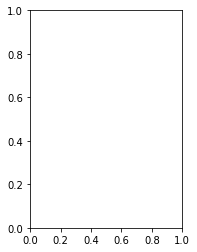

In [23]:
# Histogram Italian Food (Ratings)
plt.figure()

# bin sizes for the histogram
rating_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.0]

# Subplot 1 (Italian)
plt.subplot(121)
combined_data["Italian Average Rating"].plot.hist(bins=rating_bins, color="blue", alpha=0.6)
plt.xlabel("Italian Restaurant Ratings")
plt.xlim([1, 5.0])
plt.ylim([0, 400])

# Subplot 2 (Mexican)
plt.subplot(122)
combined_data["Mexican Average Rating"].plot.hist(bins=rating_bins, color="red", alpha=0.6)
plt.xlabel("Mexican Retaurant Ratings")
plt.xlim([1, 5.0])
plt.ylim([0, 400])

# Show Plot
plt.show()

## Statistical Analysis

In [ ]:
# Run a t-test on average rating and number of reviewers
mexican_ratings = combined_data["Mexican Average Rating"]
italian_ratings = combined_data["Italian Average Rating"]

mexican_review_counts = combined_data["Mexican Review Count"]
italian_review_counts = combined_data["Italian Review Count"]

In [ ]:
# Run T-Test on Ratings
ttest_ind(mexican_ratings.values, italian_ratings.values)

In [24]:
# Run T-Test on Review Counts
ttest_ind(mexican_review_counts.values, italian_review_counts.values)

NameError: name 'mexican_review_counts' is not defined

## Conclusions
---
Based on our analysis, it is clear that American preference for Italian and Mexican food are very similar in nature. As a whole, Americans rate Mexican and Italian restaurants at statistically similar scores. However, there does exist evidence that Americans do write more reviews on Italian restaurants. This may indicate that there is an increased interest in visiting Italian restaurants at an experiential level. (However, this data may also merely suggest that Yelp users happen to enjoy writing reviews on Italian restaurants more).